# Classifier Autoencoder

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
wine_df = pd.read_csv('./winequality-red.csv')

In [3]:
wine_feat = wine_df.iloc[:, :-1]
wine_quality = wine_df['quality']

In [4]:
uniques, counts = np.unique(wine_quality, return_counts=True)
sizes = counts/counts.sum()

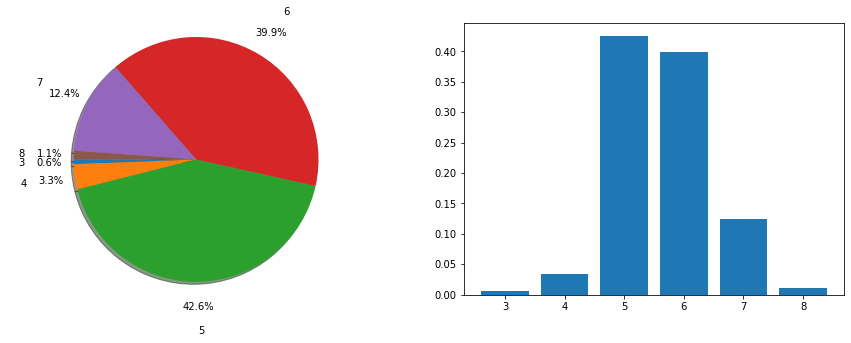

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].pie(sizes,labels=uniques, autopct='%1.1f%%',pctdistance=1.2, labeldistance=1.4,
        shadow=True, startangle=180)
axes[0].axis('equal')

axes[1].bar(range(len(sizes)), sizes)
axes[1].set_xticks(range(len(sizes)))
axes[1].set_xticklabels(uniques)
plt.show()

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

In [32]:
class Encoder(Model):
    def __init__(self, z_dim=5, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.dense_0 = Dense(64, name='Edense_0')
        self.dense_1 = Dense(32, name='Edense_1')
        self.dense_2 = Dense(16, name='Edense_2')
        self.dense_3 = Dense(z_dim)
        
    def call(self, x):
        x = tf.cast(x, tf.float32)
        x = self.dense_0(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        z = self.dense_3(x)
        return z

In [33]:
class Decoder(Model):
    def __init__(self, out_dim=11, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.dense_0 = Dense(16, name='Ddense_0')
        self.dense_1 = Dense(32, name='Ddense_0')
        self.dense_2 = Dense(64, name='Ddense_0')
        self.dense_3 = Dense(out_dim)
        
    def call(self, x):
        x = self.dense_0(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        rec = self.dense_3(x)
        return rec

In [67]:
class Classifier(Model):
    def __init__(self, out_dim=11, n_classes=6, **kwargs):
        super(Classifier, self).__init__(**kwargs)

        self.dense_0 = Dense(16, name='Ddense_0')
        self.dense_1 = Dense(32, name='Ddense_0')
        self.dense_2 = Dense(n_classes, activation='softmax')
        
    def call(self, x):
        x = self.dense_0(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return x

In [187]:
class AutoEncoder(Model):
    def __init__(self, z_dim=6, out_dim=11, n_classes=6, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)

        self.encoder = Encoder(z_dim, name='Encoder')
        self.decoder = Decoder(out_dim, name='Decoder')
        self.classifier = Classifier(n_classes=n_classes)
        
    def call(self, x):
        x = self.encoder(x)
        y = self.classifier(x)
        x = self.decoder(x)
        return x, y

    def model(self):
        x = Input((11), name='Input')
        return Model(inputs=x, outputs=self(x))
    
    def compile(self, rec_loss, class_loss, **kwargs):
        super(AutoEncoder, self).compile(**kwargs)
        self.loss_rec = rec_loss
        self.loss_class = class_loss
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            x_rec, y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            rec_loss = self.loss_rec(x, x_rec)
            class_loss = self.loss_class(y, y_pred)
            total_loss = rec_loss + class_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        
        # Add losses
        self.add_metric(total_loss, aggregation='mean', name='total')
        self.add_metric(rec_loss, aggregation='mean', name='rec')
        self.add_metric(class_loss, aggregation='mean', name='cce')
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            x_rec, y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            rec_loss = self.loss_rec(x, x_rec)
            class_loss = self.loss_class(y, y_pred)
            total_loss = rec_loss + class_loss
        
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        
        # Add losses
        self.add_metric(total_loss, aggregation='mean', name='total')
        self.add_metric(rec_loss, aggregation='mean', name='rec')
        self.add_metric(class_loss, aggregation='mean', name='cce')
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


In [188]:
model = AutoEncoder(z_dim=2, out_dim=11, name='AutoEncoder')

In [189]:
# It is important to run the model() method
model.model().summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 11)]              0         
_________________________________________________________________
AutoEncoder (AutoEncoder)    ((None, 11), (None, 6))   7619      
Total params: 7,619
Trainable params: 7,619
Non-trainable params: 0
_________________________________________________________________


In [190]:
model.compile(rec_loss=tf.keras.losses.MeanSquaredError(),
              class_loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['MSE', 'accuracy'])

In [191]:
n_classes = len(np.unique(wine_quality))
x_train = wine_feat.values
y_train = tf.one_hot(wine_quality.values, n_classes)

In [192]:
estop = tf.keras.callbacks.EarlyStopping(monitor='total', restore_best_weights=False)
tboard = tf.keras.callbacks.TensorBoard(
            log_dir='./logs', histogram_freq=1, write_graph=True,
            write_images=False, update_freq='epoch'
        )

In [193]:
! rm -r ./logs
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=1000,
                    verbose=0,
                    callbacks=[tboard, estop],
                    validation_split=0.2)

In [194]:
r = model.evaluate(x_train, y_train)

50/50 [==============================] - 0s 871us/step - MSE: 0.2348 - accuracy: 0.5347 - total: 63.2766 - rec: 57.6248 - cce: 5.6518


# Visualizing latent space

In [195]:
try:
    import umap
except:
    !pip install umap-learn
    import umap

In [196]:
reducer = umap.UMAP(n_components=2)

In [197]:
z_latent = model.encoder(x_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [198]:
embedding = reducer.fit_transform(z_latent)

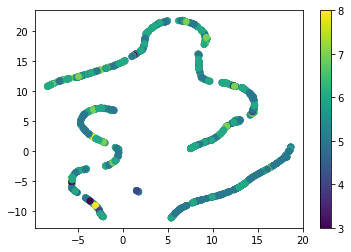

In [199]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=wine_quality.values)
plt.colorbar()